# Linguaggi regolari e automi a stati finiti

In [ ]:
from liblet import (
    Grammar, 
    Production,
    Derivation,
    Transition,
    Automaton,
    StateTransitionGraph, 
    Queue, 
    closure,
    prods2table,
    iter2table,
    dod2table,
    union_of, 
)


## Il linguaggio della parte aperta delle forme sentenziali (Sez 5.1.1)

In [ ]:
# pag. 27, Sec 2.4.3

C = Grammar.from_string("""
S -> N | L & N
L -> N ,  L | N
N -> t | d | h
""")
prods2table(C)

In [ ]:
# una derivazione in C la cui parte "aperta" è 'N & N'

Derivation(C).leftmost((1, 2, 4, 3))

S -> L & N -> N , L & N -> t , L & N -> t , N & N

In [ ]:
def open_regular(G):

    def bar(symbol):
        return symbol if symbol in G.T else symbol + '\u0305' # aggiunge una barra sopra

    T = {bar(G.S)}
    P = {Production('R', (G.S, )), Production('R', (bar(G.S), ))}

    for A, α in G.P:
        while True:
            if α == ('ε', ) or not α: break   
            Xbar, *αbar = map(bar, α)
            X, *α = α
            P.add(Production(A, [Xbar] + αbar))
            if X in G.T: continue
            T.add(Xbar)
            P.add(Production(A, [X] + αbar))
        P.add(Production(A, ('ε',)))

    # sorted garantisce che l'ordine delle produzioni non dipenda
    # dall'ordine in cui sono aggiunte al set — che in python non 
    # preserva l'ordine
    return Grammar(G.N | {'R'}, G.T | T, sorted(P), 'R')

In [ ]:
G = open_regular(C)

iter2table(G.P)

In [ ]:
# Una derivazione in G di 'N & N'

Derivation(G).leftmost((12, 15, 5))

R -> S -> L & N̅ -> N̅ & N̅

## Generazione e NFA (Sez. 5.2)

In [ ]:
# fig. 5.6, pag. 142

G = Grammar.from_string("""
S -> a A
S -> a B
A -> b B
A -> b C
B -> c A
B -> c C
C -> a
""")
G

Grammar(N={A, B, C, S}, T={a, b, c}, P=(S -> a A, S -> a B, A -> b B, A -> b C, B -> c A, B -> c C, C -> a), S=S)

In [ ]:
A = Automaton.from_grammar(G)
A

Automaton(N={A, B, C, S, ◇}, T={a, b, c}, transitions=(S-a->A, S-a->B, A-b->B, A-b->C, B-c->A, B-c->C, C-a->◇), F={◇}, q0=S)

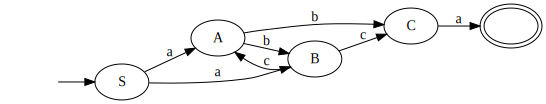

In [ ]:
StateTransitionGraph.from_automaton(A)

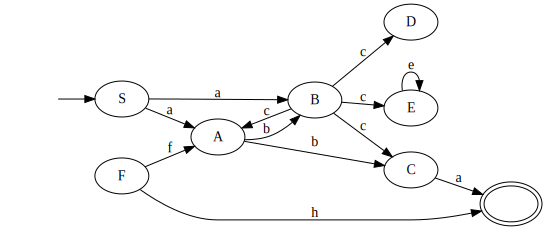

In [ ]:
# pag. 143

Gp = Grammar.from_string("""
S -> a A
S -> a B
A -> b B
A -> b C
B -> c A
B -> c C
C -> a
B -> c D
B -> c E
E -> e E
F -> f A
F -> h
""")
Gp.T -= {'D'}
Gp.N |= {'D'}

StateTransitionGraph.from_automaton(Automaton.from_grammar(Gp))

## Parsing (Sez. 5.3)

### La set construction (Sez. 5.3.1)

In [ ]:
Ns = set()
Ts = A.T
Ss = frozenset(A.q0)

transitions = []

q = Queue([Ss])
while q:
    Xs = q.dequeue()
    if Xs in Ns: continue
    for t in Ts:
        Ys = frozenset(union_of(A.δ(X, t) for X in Xs))
        if Ys: 
            transitions.append(Transition(Xs, t, Ys))
            q.enqueue(Ys)
    Ns.add(Xs)

Fs = {Xs for Xs in Ns if A.F & Xs}

As = Automaton(Ns, Ts, transitions, Ss, Fs)
As

Automaton(N={{A, B}, {A, C}, {B, C}, {S}, {◇}}, T={a, b, c}, transitions=({S}-a->{A, B}, {A, B}-c->{A, C}, {A, B}-b->{B, C}, {A, C}-b->{B, C}, {A, C}-a->{◇}, {B, C}-c->{A, C}, {B, C}-a->{◇}), F={{◇}}, q0={S})

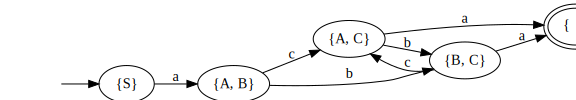

In [ ]:
StateTransitionGraph.from_automaton(As, False)

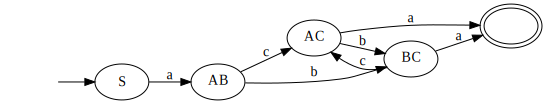

In [ ]:
StateTransitionGraph.from_automaton(As)

#### Rappresentazione tabellare dell'automa

In [ ]:
dod = {}
for Xs in As.N - {frozenset('◇')}:
    dod[''.join(sorted(Xs))] = {t: ''.join(sorted(next(iter(As.δ(Xs, t)), ''))) for t in sorted(As.T)}

dod2table(dod)        

### Con le ε-transizioni (Sez. 5.3.2)

In [ ]:
# fig. 5.14, pag. 147

A = Automaton.from_grammar(Grammar.from_string("""
S -> A
S -> a B
A -> a A
A -> ε
B -> b B
B -> b
"""))
A

Automaton(N={A, B, S, ◇}, T={a, b}, transitions=(S-ε->A, S-a->B, A-a->A, A-ε->◇, B-b->B, B-b->◇), F={◇}, q0=S)

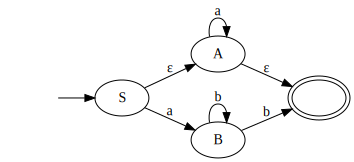

In [ ]:
StateTransitionGraph.from_automaton(A)

In [ ]:
@closure
def ε_closure(S, A):
    return S | {Y for X, x, Y in A.transitions if x == 'ε' and X in S}

ε_closure({'S'}, A)

{'A', 'S', '◇'}

In [ ]:
Ns = set()
Ts = A.T
Ss = ε_closure(frozenset(A.q0), A)

transitions = []

q = Queue([Ss])
while q:
    Xs = q.dequeue()
    if Xs in Ns: continue
    for t in Ts:
        Ys = ε_closure(frozenset(union_of(A.δ(X, t) for X in Xs)), A)
        if Ys: 
            transitions.append(Transition(Xs, t, Ys))
            q.enqueue(Ys)
    Ns.add(Xs)

Fs = {Xs for Xs in Ns if A.F & Xs}

As = Automaton(Ns, Ts, transitions, Ss, Fs)
As

Automaton(N={{A, B, ◇}, {A, S, ◇}, {A, ◇}, {B, ◇}}, T={a, b}, transitions=({A, S, ◇}-a->{A, B, ◇}, {A, B, ◇}-b->{B, ◇}, {A, B, ◇}-a->{A, ◇}, {B, ◇}-b->{B, ◇}, {A, ◇}-a->{A, ◇}), F={{A, B, ◇}, {A, S, ◇}, {A, ◇}, {B, ◇}}, q0={A, S, ◇})

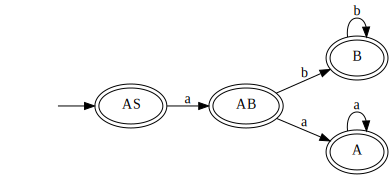

In [ ]:
StateTransitionGraph.from_automaton(As)